In [47]:
import pandas as pd
import numpy as np
import seaborn as sn 
import matplotlib.pyplot as plt 
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans


# Data Processing

In [48]:
# Read in data from csv into a dataframe
spotify_df = pd.read_csv('spotify_songs.csv')

In [49]:
# Determine genres and subgenres
genres = spotify_df['playlist_genre'].unique()
subgenres = spotify_df['playlist_subgenre'].unique()
print("genres:\n", genres)
print("subgenres:\n", subgenres)

genres:
 ['pop' 'rap' 'rock' 'latin' 'r&b' 'edm']
subgenres:
 ['dance pop' 'post-teen pop' 'electropop' 'indie poptimism' 'hip hop'
 'southern hip hop' 'gangster rap' 'trap' 'album rock' 'classic rock'
 'permanent wave' 'hard rock' 'tropical' 'latin pop' 'reggaeton'
 'latin hip hop' 'urban contemporary' 'hip pop' 'new jack swing'
 'neo soul' 'electro house' 'big room' 'pop edm'
 'progressive electro house']


In [50]:
spotify_df['popularity_discrete'] = np.where(spotify_df['track_popularity'] >= 75, 'popular', 'unpopular')
# Convert to datetime format to be able to do computations like sorting
spotify_df['track_album_release_date_dt'] = pd.to_datetime(spotify_df['track_album_release_date'])
# Determine relevant features
features = np.array(['track_name', 'track_popularity', 'track_album_release_date_dt'] + spotify_df.columns[9:-1].to_list())
# Filter the dataframe by relevant features
filtered_spotify_df = spotify_df[features].sort_values('track_popularity').reset_index(drop=True)
# Create a dictionary of dataframes for each subgenre
dict_df = {}
genre_dict = {}
for g in genres:
    genre_dict[g] = filtered_spotify_df[filtered_spotify_df['playlist_genre'] == g].reset_index(drop = True).drop(columns = ['playlist_genre', 'playlist_subgenre'])
    
for sg in subgenres:
    dict_df[sg] = filtered_spotify_df[filtered_spotify_df['playlist_subgenre'] == sg].reset_index(drop = True).drop(columns = ['playlist_genre', 'playlist_subgenre'])
    

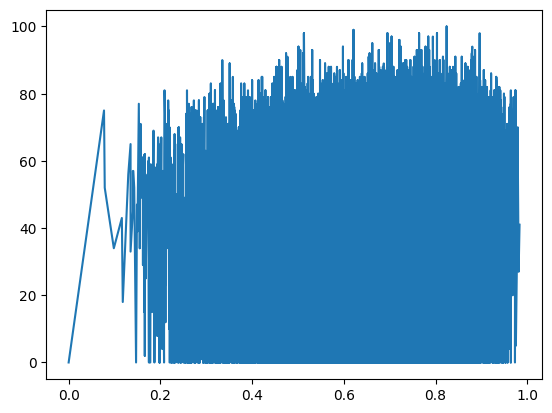

In [51]:

# explore relationship between popularity and, e.g., danceability
graph_df = filtered_spotify_df.sort_values('danceability')
plt.plot(graph_df['danceability'], graph_df['track_popularity'])

In [52]:
def data_balancing(df, under = True):
    #undersample the bigger label
    if under:
        min_label = df['popularity_discrete'].value_counts().idxmin()
        max_label = df['popularity_discrete'].value_counts().idxmax()
        
        smaller_df = df[df['popularity_discrete'] == min_label]
        larger_df = df[df['popularity_discrete'] == max_label]
        
        match_count = df['popularity_discrete'].value_counts().min()
        
        sampled_df = larger_df.sample(n=match_count, replace=True, ignore_index=True)
        
        return pd.concat([sampled_df, smaller_df], ignore_index = True)
        
    #oversample the smaller label
    else:
        min_label = df['popularity_discrete'].value_counts().idxmin()
        max_label = df['popularity_discrete'].value_counts().idxmax()
        
        smaller_df = df[df['popularity_discrete'] == min_label]
        larger_df = df[df['popularity_discrete'] == max_label]
        
        match_count = df['popularity_discrete'].value_counts().max()
        
        sampled_df = smaller_df.sample(n=match_count, replace=True, ignore_index=True)
        
        return pd.concat([sampled_df, larger_df], ignore_index = True)
        

In [53]:
# normalize function
def normalize(df):
    for c in df.columns:
        if df[c].dtype == int or df[c].dtype == float:
            df[c] /= df[c].abs().max()

In [54]:
def correlation_matrix(features):
    data = features.corr().abs() 

    # plotting the heatmap 
    hm = sn.heatmap(data = data) 

    # displaying the plotted heatmap 
    plt.show()

In [55]:
def train_test_features_labels(df, test_size = 0.7):
    X = df.drop(columns = ['track_name', 'key', 'mode', 'track_album_release_date_dt', 'track_popularity', 'popularity_discrete'])
    y = df['track_popularity']
    y_discrete = df['popularity_discrete']
    dX_train, dX_test, dy_train, dy_test = train_test_split(X, y_discrete, test_size=test_size, shuffle = True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = True)
    
    return X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test

In [56]:
subgenres

array(['dance pop', 'post-teen pop', 'electropop', 'indie poptimism',
       'hip hop', 'southern hip hop', 'gangster rap', 'trap',
       'album rock', 'classic rock', 'permanent wave', 'hard rock',
       'tropical', 'latin pop', 'reggaeton', 'latin hip hop',
       'urban contemporary', 'hip pop', 'new jack swing', 'neo soul',
       'electro house', 'big room', 'pop edm',
       'progressive electro house'], dtype=object)

In [57]:
# take a subgenre dataframe
df = genre_dict['pop']
normalize(df)
under_df = data_balancing(df, under = True)
over_df = data_balancing(df, under = False)
X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)

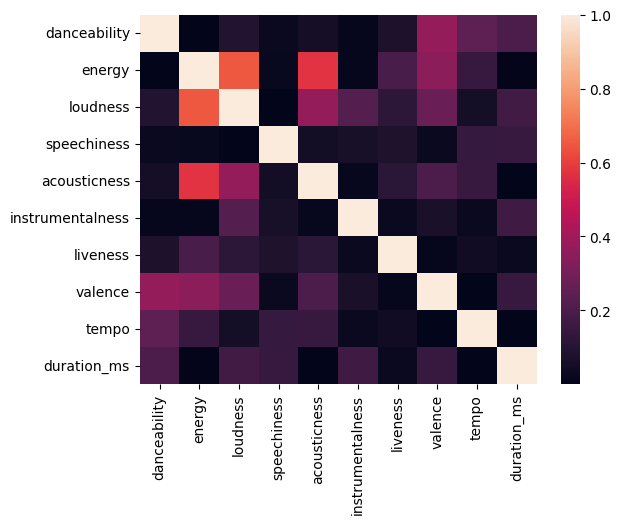

In [58]:
correlation_matrix(X)

# Models

## Hyperparameterization

In [88]:
def runTuneTest(learner, parameters, X,y, verbose = False):
    # Apply KFold with 5 folds
    kf = KFold(n_splits = 5) 
    X = X.to_numpy()
    if type(y) == list: #list
        y = np.array(y_transformed_discrete)
    else: # dataframe
        y = y.to_numpy()
    score_sum = 0
    for train, test in kf.split(X, y):
        # Determine hyperparameters using wrapper class GridSearchCV
        gs_wrapper = GridSearchCV(learner, parameters, cv = 3)
        gs_wrapper.fit(X[train], y[train])
        # Print parameter settings that give the best results on the hold out data
        score_sum += gs_wrapper.best_score_

        if verbose:
            print("best score: ", gs_wrapper.best_score_)
            print("best estimator: ", gs_wrapper.best_estimator_)
        
    return score_sum / 5

## Supervised

### KNN

In [89]:
neigh = KNeighborsClassifier()
neigh.fit(dX_train, dy_train)
print(neigh.score(dX_test, dy_test))

0.5967184801381693


In [90]:
def KNNPipe(X, y_discrete, verbose = False):
    score = runTuneTest(KNeighborsClassifier(), {}, X, y_discrete, verbose)
    if verbose:
        print("average score: ", score)
    return score

### Linear SVM

In [91]:
def linearSVMPipe(X, y_discrete, verbose = False):
    grid_values = {
        'dual': [True, False],
        'fit_intercept': [True, False],
    }    
    score = runTuneTest(LinearSVC(), grid_values, X, y_discrete, verbose)
    if verbose:
        print("average score: ", score)
    return score

In [92]:
linearSVMPipe(X, y_discrete)

0.6448049305192163

In [93]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False))
clf.fit(dX_train, dy_train)
print(clf.score(dX_test, dy_test))

0.6450777202072538


### Logistic Regression

In [94]:
def logRegPipe(X, y_discrete, verbose = False):
    grid_values = {
        'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
        'C': [0.1, 0.25, 0.5, 1, 1.5, 2],
        'fit_intercept': [True, False]
    }
    score = runTuneTest(LogisticRegression(), grid_values, X, y_discrete, verbose)
    if verbose:
        print("average score: ", score)
    return score


In [95]:
logRegPipe(X, y_discrete)

0.6478269940454814

In [96]:
lr = LogisticRegression(C = 0.1)
lr.fit(dX_train, dy_train)
print(lr.score(dX_test, dy_test))

0.5647668393782384


In [97]:
lr.feature_names_in_

array(['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'], dtype=object)

In [98]:
lr.coef_

array([[-0.16920415,  0.35191601, -0.18369237, -0.05455951, -0.19967178,
         0.56485665,  0.25100778, -0.14828137,  0.10465928,  0.08840239]])

In [99]:
X.corr().abs()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
danceability,1.000000,0.003663,0.091296,0.029248,0.056479,0.013312,0.077134,0.371762,0.243543,0.202079
energy,0.003663,1.000000,0.651193,0.022414,0.573924,0.012171,0.192436,0.354627,0.144826,0.007782
loudness,0.091296,0.651193,1.000000,0.000220,0.372230,0.222591,0.120273,0.270189,0.051253,0.174491
speechiness,0.029248,0.022414,0.000220,1.000000,0.050714,0.065713,0.082135,0.025878,0.144688,0.148293
acousticness,0.056479,0.573924,0.372230,0.050714,1.000000,0.017643,0.113166,0.201813,0.144975,0.002897
instrumentalness,0.013312,0.012171,0.222591,0.065713,0.017643,1.000000,0.026470,0.070359,0.027587,0.167361
liveness,0.077134,0.192436,0.120273,0.082135,0.113166,0.026470,1.000000,0.015487,0.044943,0.026665
valence,0.371762,0.354627,0.270189,0.025878,0.201813,0.070359,0.015487,1.000000,0.001502,0.145501
tempo,0.243543,0.144826,0.051253,0.144688,0.144975,0.027587,0.044943,0.001502,1.000000,0.003692
duration_ms,0.202079,0.007782,0.174491,0.148293,0.002897,0.167361,0.026665,0.145501,0.003692,1.000000


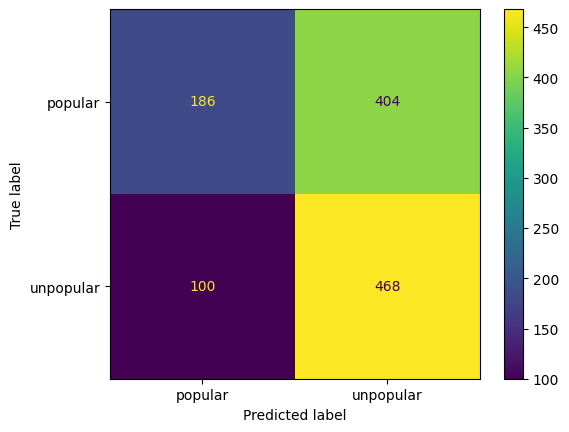

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = lr.predict(dX_test)
confmat = confusion_matrix(dy_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=lr.classes_)
disp.plot()
plt.show()

### Decision Tree

In [101]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(dX_train, dy_train)
print(dt.score(dX_train, dy_train))
print(dt.score(dX_test, dy_test))
predictions = dt.predict(dX_test)
#print(f1_score(dy_test, predictions, pos_label='popular'))
# care about F score



0.6733870967741935
0.6347150259067358


In [102]:
def DTPipe(X, y_discrete, verbose = False):
    features = len(X.columns)
    grid_values = {
        'max_depth': [
            i for i in range(1, features)
        ],
        'min_samples_split': [
            2,
            5,
            10,
            50,
            100,
            200,
            300,
            317
        ]
    }
    score = runTuneTest(DecisionTreeClassifier(), grid_values, X, y_discrete, verbose)
    if verbose:
        print("average score: ", score)
    return score

In [103]:
DTPipe(X, y_discrete)

0.6587031393754084

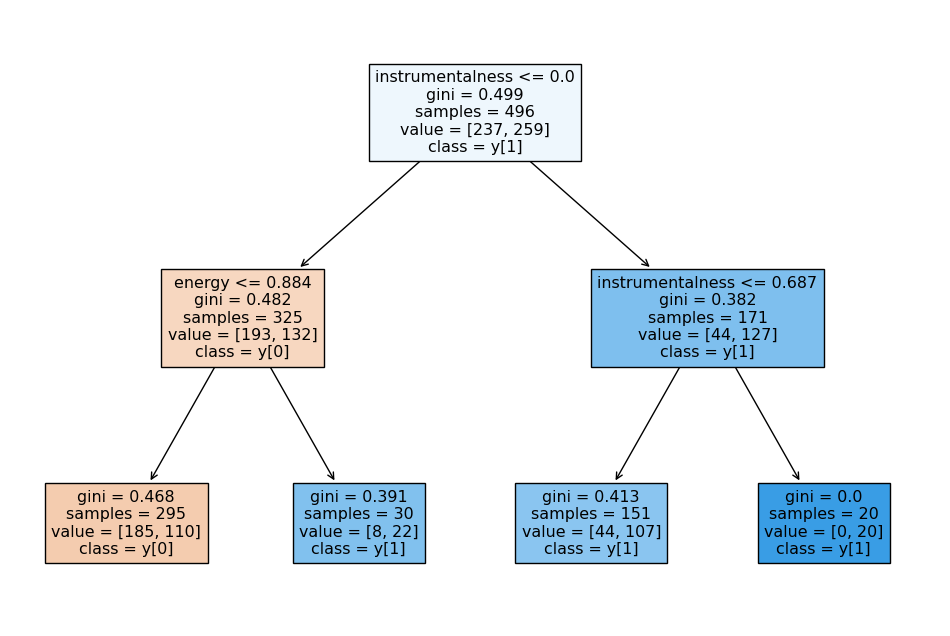

In [104]:
from sklearn.tree import plot_tree
# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt, filled=True, feature_names=dX_train.columns, class_names=True)
plt.show()


In [105]:
from sklearn.metrics import confusion_matrix
predictions = dt.predict(dX_test)
confmat = confusion_matrix(dy_test, predictions)

In [106]:
confmat

array([[414, 176],
       [247, 321]])

### Random Forest

In [107]:
rf = RandomForestClassifier()
rf.fit(dX_train, dy_train)
print(rf.score(dX_train, dy_train))
print(rf.score(dX_test, dy_test))
predictions = rf.predict(dX_test)
#print(f1_score(dy_test, predictions, pos_label='popular'))

print("%18s | %s" % ("(rf) feature", "weight"))
print("======================================")
pairs = []
for i in range(len(rf.feature_names_in_)):
    pairs.append((abs(rf.feature_importances_[i]), rf.feature_names_in_[i]))
pairs.sort()
for i in reversed(range(len(rf.feature_names_in_))):
    print("%18s = %.3f" % (pairs[i][1], pairs[i][0]))
rf.classes_


0.9939516129032258
0.6485319516407599
      (rf) feature | weight
  instrumentalness = 0.132
          loudness = 0.106
            energy = 0.103
       speechiness = 0.102
      danceability = 0.100
           valence = 0.097
      acousticness = 0.095
          liveness = 0.094
             tempo = 0.088
       duration_ms = 0.084


array(['popular', 'unpopular'], dtype=object)

In [108]:
def RFPipe(X, y_discrete, verbose = False):
    features = len(X.columns)
    grid_values = {
        'max_depth': [
            i for i in range(1, features)
        ],
        'n_estimators': [
            1,
            10,
            100
        ]
    }
    score = runTuneTest(RandomForestClassifier(), grid_values, X, y_discrete, verbose)
    if verbose:
        print("average score: ", score)
    return score

In [109]:
RFPipe(X, y_discrete, verbose = True)

best score:  0.6848072562358277
best estimator:  RandomForestClassifier(max_depth=5)
best score:  0.693121693121693
best estimator:  RandomForestClassifier(max_depth=8)
best score:  0.6848072562358277
best estimator:  RandomForestClassifier(max_depth=7)
best score:  0.671201814058957
best estimator:  RandomForestClassifier(max_depth=5)
best score:  0.6661570611150444
best estimator:  RandomForestClassifier(max_depth=9)
average score:  0.68001901615347


0.68001901615347

### Boosting

In [110]:
gb = GradientBoostingClassifier()
gb.fit(dX_train, dy_train)
print(gb.score(dX_train, dy_train))
print(gb.score(dX_test, dy_test))
predictions = gb.predict(dX_test)


0.9435483870967742
0.6580310880829016


In [111]:
def BoostingPipe(X, y_discrete, verbose = False):
    grid_values = {
        'learning_rate': [0.1, 0.5, 0.9],
        'n_estimators': [1,10,100],
        'subsample': [0.1, 0.5, 0.9]
    }
    score = runTuneTest(GradientBoostingClassifier(), grid_values, X, y_discrete, verbose)
    if verbose:
        print("average score: ", score)
    return score

In [112]:
BoostingPipe(X, y_discrete)

0.6718581449673887

## Unsupervised

### K-Means

In [113]:
def KMeanPipe(X, clusters = 8):
    km = KMeans(n_clusters = clusters)
    km.fit(X)
    km_labels = pd.Series(km.labels_)
    plt.scatter(km_labels, y)


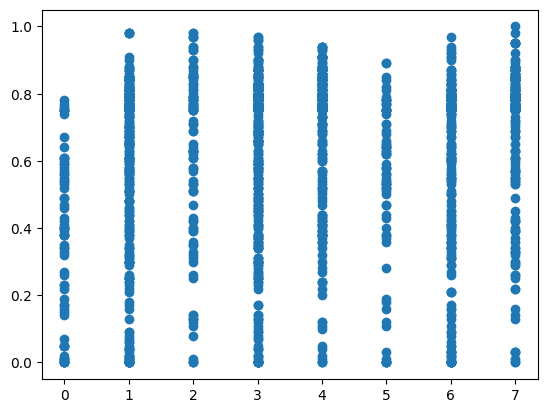

In [114]:
KMeanPipe(X)

# Experimentation

In [115]:
from tqdm import tqdm

In [116]:
results = pd.DataFrame()
results['genres'] = genres


In [117]:
uknns = []
usvms = []
ulrs = []
udts = []
urfs = []
uboos = []
oknns = []
osvms = []
olrs = []
odts = []
orfs = []
oboos = []

for g in tqdm(genres):
    df = genre_dict[g]
    normalize(df)
    under_df = data_balancing(df, under = True)
    over_df = data_balancing(df, under = False)
    X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)
    
    # KMeanPipe(X)
    uknns.append(KNNPipe(X, y_discrete))
    usvms.append(linearSVMPipe(X, y_discrete))
    ulrs.append(logRegPipe(X, y_discrete))
    udts.append(DTPipe(X, y_discrete))
    urfs.append(RFPipe(X, y_discrete))
    uboos.append(BoostingPipe(X, y_discrete))
    
    X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(over_df)
    
    # KMeanPipe(X)
    oknns.append(KNNPipe(X, y_discrete))
    osvms.append(linearSVMPipe(X, y_discrete))
    olrs.append(logRegPipe(X, y_discrete))
    odts.append(DTPipe(X, y_discrete))
    orfs.append(RFPipe(X, y_discrete))
    oboos.append(BoostingPipe(X, y_discrete))
    

100%|████████████████████████████████████████████████| 6/6 [19:46<00:00, 197.80s/it]


In [267]:
uknns = []
usvms = []
ulrs = []
udts = []
urfs = []
uboos = []
oknns = []
osvms = []
olrs = []
odts = []
orfs = []
oboos = []

for sg in tqdm(subgenres):
    df = dict_df[sg]
    normalize(df)
    under_df = data_balancing(df, under = True)
    over_df = data_balancing(df, under = False)
    X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)
    
    # KMeanPipe(X)
    uknns.append(KNNPipe(X, y_discrete))
    usvms.append(linearSVMPipe(X, y_discrete))
    ulrs.append(logRegPipe(X, y_discrete))
    udts.append(DTPipe(X, y_discrete))
    urfs.append(RFPipe(X, y_discrete))
    uboos.append(BoostingPipe(X, y_discrete))
    
    X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(over_df)
    
    # KMeanPipe(X)
    oknns.append(KNNPipe(X, y_discrete))
    osvms.append(linearSVMPipe(X, y_discrete))
    olrs.append(logRegPipe(X, y_discrete))
    odts.append(DTPipe(X, y_discrete))
    orfs.append(RFPipe(X, y_discrete))
    oboos.append(BoostingPipe(X, y_discrete))
    

 75%|███████████████████████████████████▎           | 18/24 [19:17<06:36, 66.09s/it]/scratch/knerr/venvs/cs66/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/scratch/knerr/venvs/cs66/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/scratch/knerr/venvs/cs66/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/scratch/knerr/venvs/cs66/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/scratch/knerr/venvs/cs66/lib/python3.10/site-packages/sklearn/base.py", line 666, in score
    return accura

In [118]:
results['under_KNN'] = uknns
results['under_Linear_SVM'] = usvms
results['under_Logistic_Regression'] = ulrs
results['under_Decisiton_Tree'] = udts
results['under_Random_Forest'] = urfs
results['under_Gradient_Boost'] = uboos

results['over_KNN'] = oknns
results['over_Linear_SVM'] = osvms
results['over_Logistic_Regression'] = olrs
results['over_Decisiton_Tree'] = odts
results['over_Random_Forest'] = orfs
results['over_Gradient_Boost'] = oboos

In [119]:
results.to_csv('genre_results.csv')

In [295]:
results_num = results.drop(columns = ['Subgenres']).fillna(0)

In [296]:
subgenre_mean = []
for c in results_num.T.columns:
    subgenre_mean.append(results_num.T[c].mean())

In [297]:
results_num.mean()

under_KNN                    0.574492
under_Linear_SVM             0.631322
under_Logistic_Regression    0.646285
under_Decisiton_Tree         0.652142
under_Random_Forest          0.693940
under_Gradient_Boost         0.684306
over_KNN                     0.826223
over_Linear_SVM              0.692658
over_Logistic_Regression     0.693646
over_Decisiton_Tree          0.859827
over_Random_Forest           0.920944
over_Gradient_Boost          0.935580
dtype: float64

In [298]:
results_num['subgenre_mean'] = subgenre_mean

In [299]:
results_num

,under_KNN,under_Linear_SVM,under_Logistic_Regression,under_Decisiton_Tree,under_Random_Forest,under_Gradient_Boost,over_KNN,over_Linear_SVM,over_Logistic_Regression,over_Decisiton_Tree,over_Random_Forest,over_Gradient_Boost,subgenre_mean
dance pop,0.576981,0.642090,0.638305,0.630087,0.662270,0.645888,0.718284,0.659992,0.663176,0.788409,0.874205,0.880222,0.698326
post-teen pop,0.574918,0.622641,0.628551,0.632496,0.660114,0.644724,0.637152,0.630533,0.635151,0.702579,0.785711,0.788326,0.661908
electropop,0.616469,0.658021,0.665899,0.652455,0.682997,0.681090,0.717872,0.666230,0.664778,0.800480,0.869890,0.888706,0.713741
indie poptimism,0.580561,0.634362,0.640210,0.625005,0.682315,0.658903,0.841130,0.656543,0.654148,0.881471,0.956789,0.962937,0.731198
hip hop,0.693152,0.710116,0.705042,0.694060,0.716196,0.709272,0.797738,0.704755,0.707199,0.844232,0.886456,0.922428,0.757554
southern hip hop,0.590765,0.621934,0.618903,0.615873,0.663059,0.651371,0.936468,0.690443,0.694113,0.948471,0.982492,0.992049,0.750495
gangster rap,0.576747,0.602218,0.618817,0.625202,0.659073,0.657527,0.906717,0.702193,0.704249,0.931201,0.972658,0.978376,0.744581
trap,0.607738,0.646695,0.641248,0.670351,0.685493,0.685546,0.804555,0.700403,0.692854,0.849021,0.928808,0.949663,0.738531
album rock,0.536949,0.590917,0.617901,0.610494,0.625309,0.622751,0.877952,0.608597,0.618091,0.826421,0.942451,0.976706,0.704545
classic rock,0.553126,0.563428,0.611336,0.597661,0.611336,0.611336,0.850467,0.616413,0.622343,0.820536,0.942771,0.965150,0.697158


In [24]:
cleaned_matrix = filtered_spotify_df.drop(columns = ['track_name', 'playlist_genre', 'playlist_subgenre', 'popularity_discrete', 'track_album_release_date_dt'])
normalize(cleaned_matrix)

In [25]:
cleaned_matrix

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.00,0.456765,0.979,1.000000,-0.198222,0.0,0.064270,0.012274,0.000000,0.416667,0.563068,0.774002,0.100139
1,0.00,0.807731,0.741,0.090909,-0.106765,1.0,0.067756,0.157948,0.033400,0.310241,0.812311,0.396784,0.473971
2,0.00,0.818922,0.852,0.909091,-0.093373,1.0,0.107407,0.439638,0.000001,0.080120,0.720484,0.392804,0.207744
3,0.00,0.758901,0.705,0.636364,-0.152536,1.0,0.054902,0.211268,0.000000,0.384538,0.546922,0.338243,0.399063
4,0.00,0.760936,0.887,0.363636,-0.134128,0.0,0.098584,0.085815,0.000000,0.108434,0.590313,0.405175,0.421983
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,0.99,0.631740,0.601,0.545455,-0.120909,0.0,0.161220,0.052515,0.000000,0.461847,0.461150,0.487533,0.316016
32829,0.99,0.631740,0.601,0.545455,-0.120909,0.0,0.161220,0.052515,0.000000,0.461847,0.461150,0.487533,0.316016
32830,0.99,0.631740,0.601,0.545455,-0.120909,0.0,0.161220,0.052515,0.000000,0.461847,0.461150,0.487533,0.316016
32831,1.00,0.838250,0.588,0.545455,-0.137788,0.0,0.100654,0.696177,0.000105,0.149598,0.517659,0.409401,0.404469


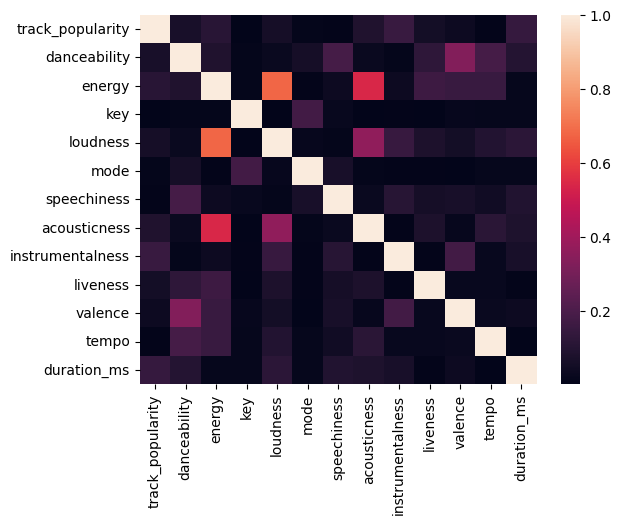

In [26]:
correlation_matrix(cleaned_matrix)

In [33]:
genres

array(['pop', 'rap', 'rock', 'latin', 'r&b', 'edm'], dtype=object)

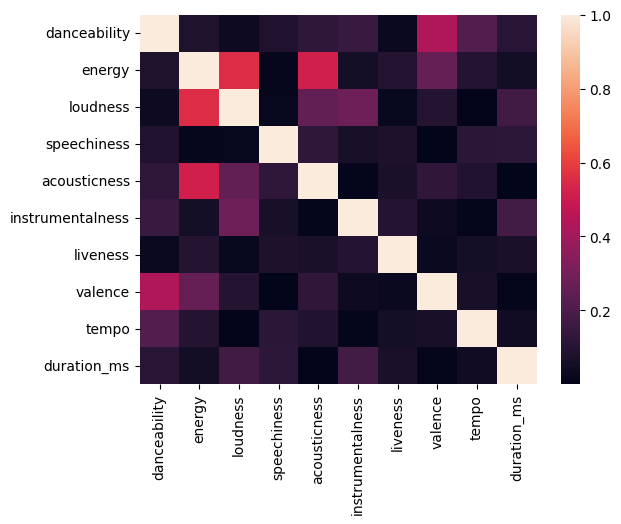

In [29]:
df = dict_df['dance pop']
normalize(df)
under_df = data_balancing(df, under = True)
over_df = data_balancing(df, under = False)
X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)
correlation_matrix(X)

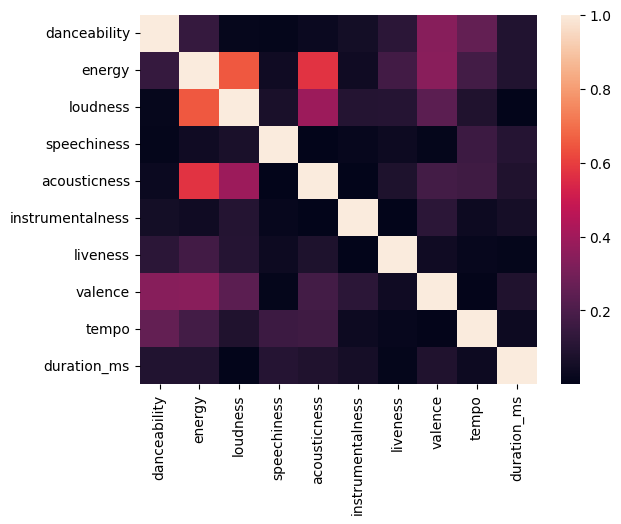

In [30]:
df = dict_df['post-teen pop']
normalize(df)
under_df = data_balancing(df, under = True)
over_df = data_balancing(df, under = False)
X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)
correlation_matrix(X)

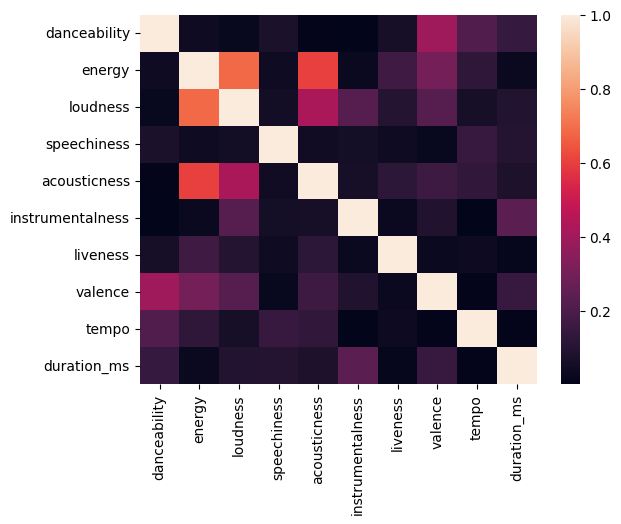

In [34]:
df = genre_dict['pop']
normalize(df)
under_df = data_balancing(df, under = True)
over_df = data_balancing(df, under = False)
X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)
correlation_matrix(X)

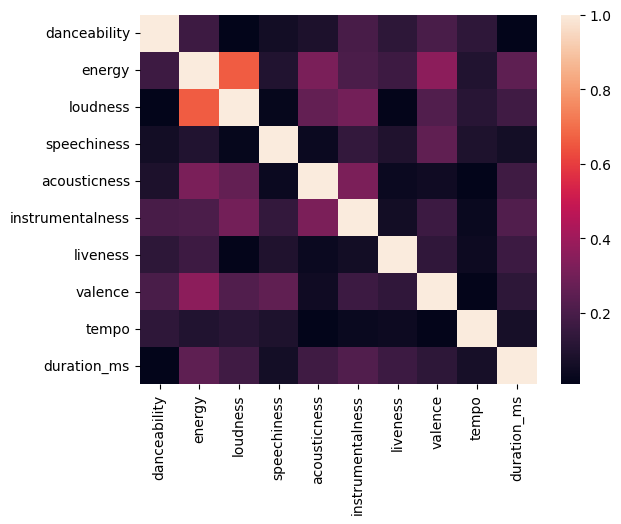

In [35]:
df = genre_dict['rap']
normalize(df)
under_df = data_balancing(df, under = True)
over_df = data_balancing(df, under = False)
X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)
correlation_matrix(X)

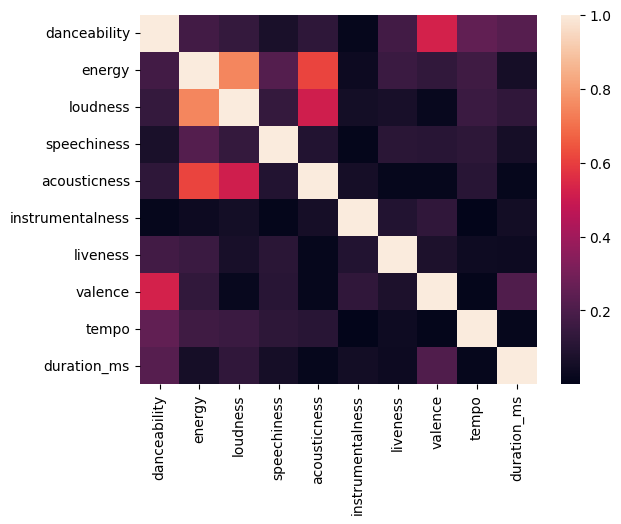

In [36]:
df = genre_dict['rock']
normalize(df)
under_df = data_balancing(df, under = True)
over_df = data_balancing(df, under = False)
X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)
correlation_matrix(X)

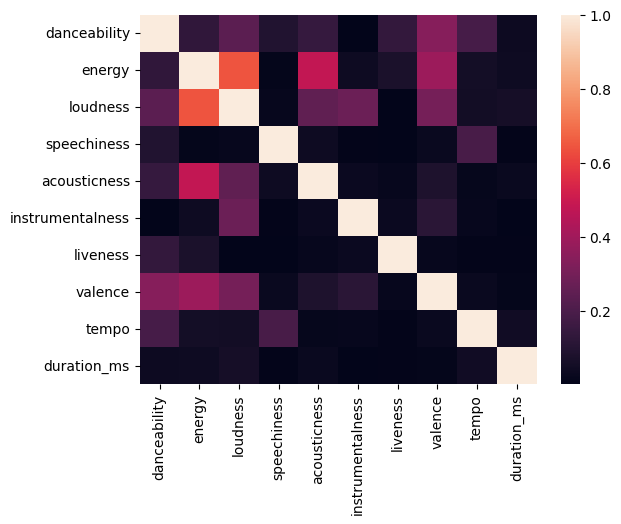

In [37]:
df = genre_dict['latin']
normalize(df)
under_df = data_balancing(df, under = True)
over_df = data_balancing(df, under = False)
X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)
correlation_matrix(X)

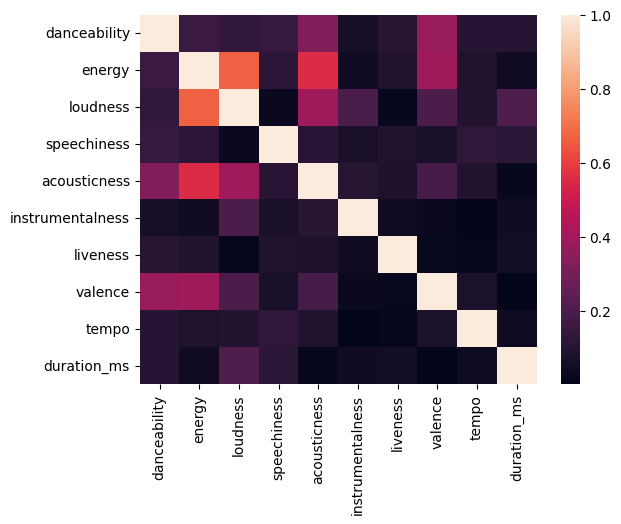

In [38]:
df = genre_dict['r&b']
normalize(df)
under_df = data_balancing(df, under = True)
over_df = data_balancing(df, under = False)
X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)
correlation_matrix(X)

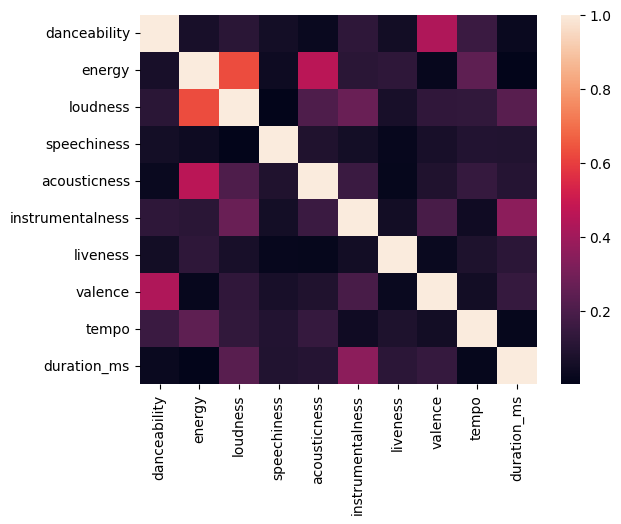

In [39]:
df = genre_dict['edm']
normalize(df)
under_df = data_balancing(df, under = True)
over_df = data_balancing(df, under = False)
X, y, y_discrete, dX_train, dX_test, dy_train, dy_test, X_train, X_test, y_train, y_test = train_test_features_labels(under_df)
correlation_matrix(X)